In [1]:
!pip install pandas scikit-learn matplotlib


Best Clustering Results:
Number of clusters: 10
Davies-Bouldin Index: 1.1727
Silhouette Score: 0.4347


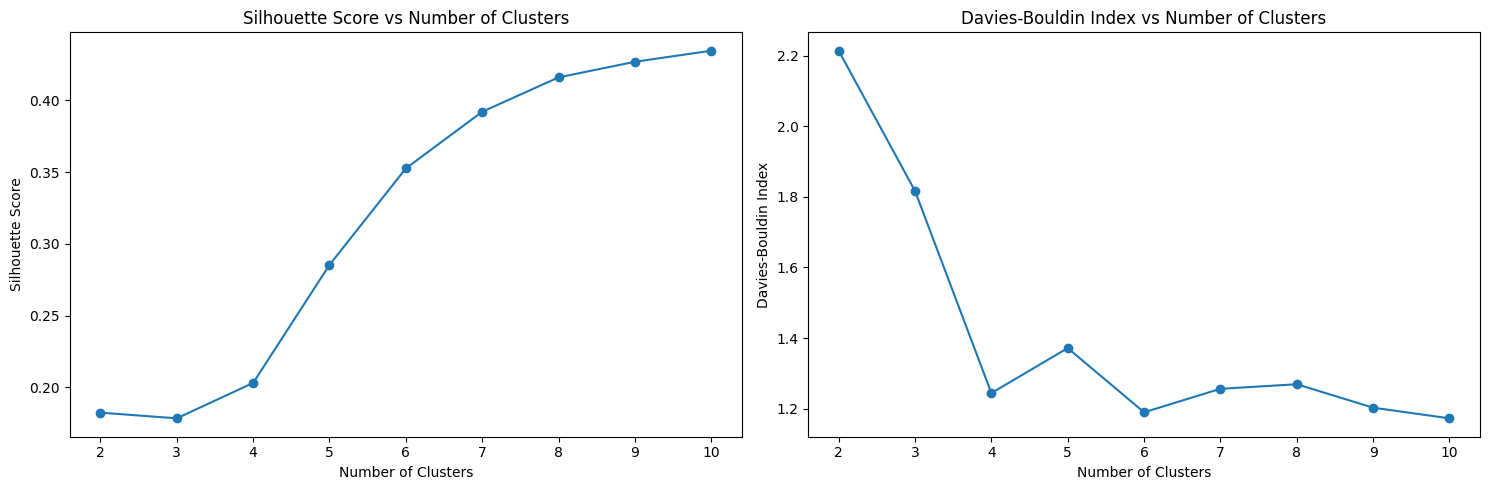

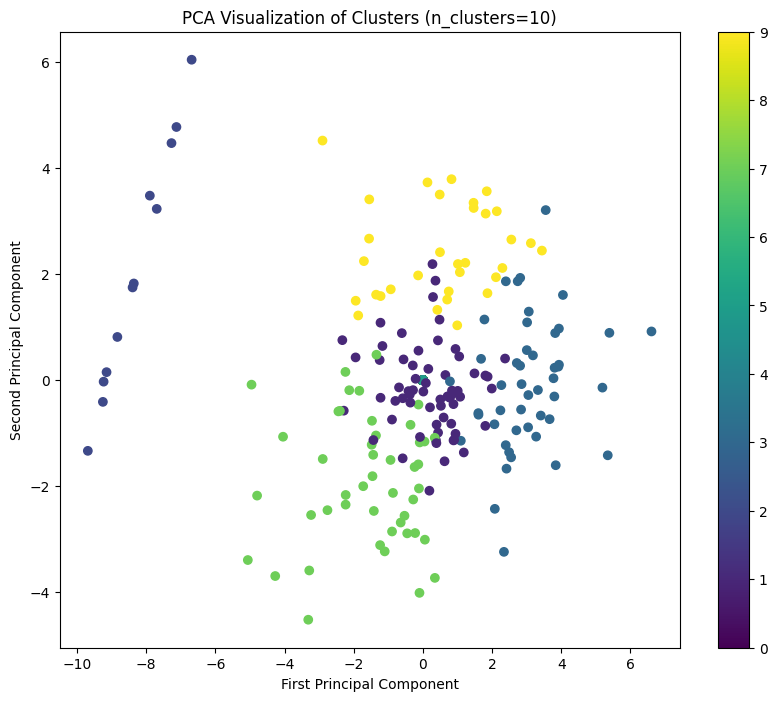

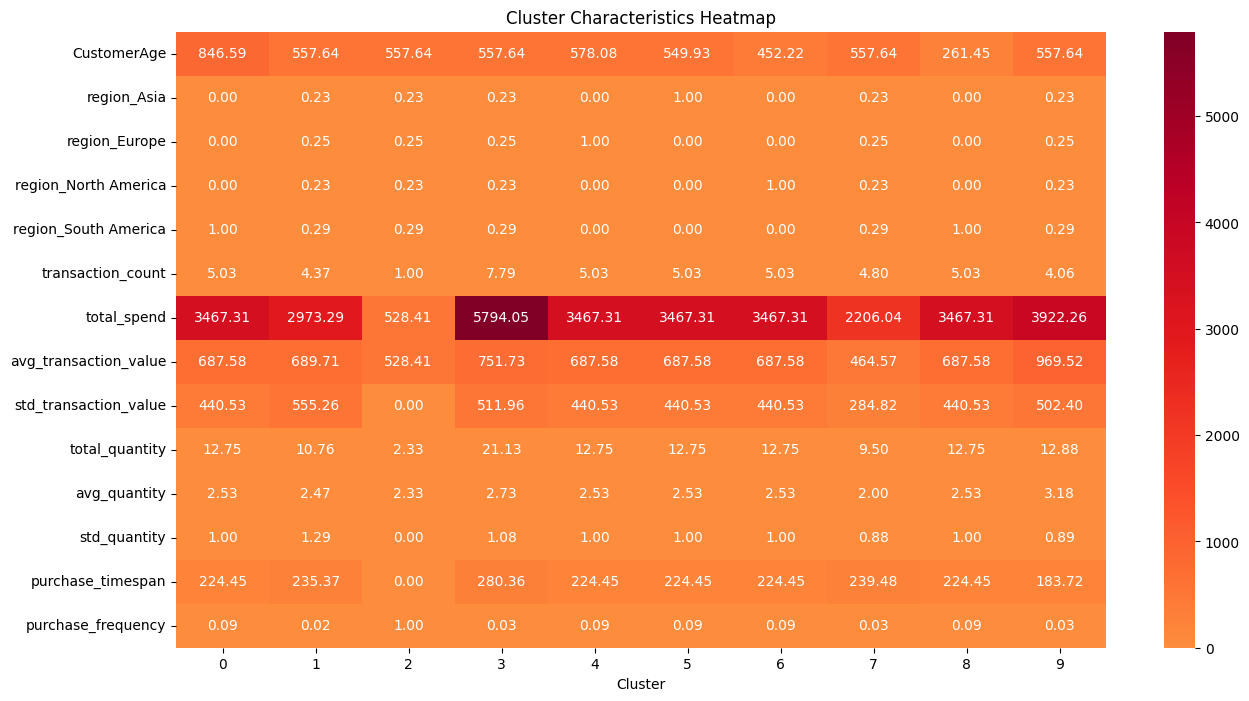

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.spatial.distance import cdist

def load_and_preprocess_data(customers_path, transactions_path):
    """Load and preprocess customer and transaction data."""
    # Load data
    customers_df = pd.read_csv(customers_path)
    transactions_df = pd.read_csv(transactions_path)

    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

    # Calculate customer age (in days)
    customers_df['CustomerAge'] = (pd.Timestamp.now() - customers_df['SignupDate']).dt.days


    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean', 'std'],
        'TransactionDate': lambda x: (x.max() - x.min()).days
    }).fillna(0)  # Fill NaN with 0 for customers with single transactions


    transaction_features.columns = [
        'transaction_count',
        'total_spend', 'avg_transaction_value', 'std_transaction_value',
        'total_quantity', 'avg_quantity', 'std_quantity',
        'purchase_timespan'
    ]


    transaction_features['purchase_frequency'] = (
        transaction_features['transaction_count'] /
        np.where(transaction_features['purchase_timespan'] == 0, 1, transaction_features['purchase_timespan'])
    )


    region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')


    features_df = pd.concat([
        customers_df[['CustomerID', 'CustomerAge']],
        region_dummies,
        transaction_features
    ], axis=1).set_index('CustomerID')

    # Replace infinite values with NaN
    features_df = features_df.replace([np.inf, -np.inf], np.nan)

    imputer = SimpleImputer(strategy='mean')
    features_imputed = pd.DataFrame(
        imputer.fit_transform(features_df),
        columns=features_df.columns,
        index=features_df.index
    )

    return features_imputed

def calculate_db_index(X, labels, centroids):
    """Calculate Davies-Bouldin Index."""
    n_clusters = len(centroids)
    cluster_distances = []


    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            cluster_distances.append(np.mean(cdist(cluster_points, [centroids[i]])))
        else:
            cluster_distances.append(0)

    # Calculate Davies-Bouldin Index
    db_index = 0
    for i in range(n_clusters):
        max_ratio = 0
        for j in range(n_clusters):
            if i != j:
                centroid_distance = np.linalg.norm(centroids[i] - centroids[j])
                if centroid_distance > 0:  #divi by zero
                    ratio = (cluster_distances[i] + cluster_distances[j]) / centroid_distance
                    max_ratio = max(max_ratio, ratio)
        db_index += max_ratio

    return db_index / n_clusters

def perform_clustering(features_df, n_clusters_range=(2, 10)):
    """Perform clustering and evaluate results."""

    scaler = StandardScaler()
    X = scaler.fit_transform(features_df)


    results = []

    for n_clusters in range(n_clusters_range[0], n_clusters_range[1] + 1):
        # Fit KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)

        # Calculate metrics
        silhouette = silhouette_score(X, labels)
        db_idx = calculate_db_index(X, labels, kmeans.cluster_centers_)

        results.append({
            'n_clusters': n_clusters,
            'silhouette': silhouette,
            'db_index': db_idx,
            'labels': labels,
            'model': kmeans
        })

    return results, X

def plot_clustering_results(results, features_df, X):
    """Create visualizations for clustering results."""
    # Plot metrics
    metrics_df = pd.DataFrame([(r['n_clusters'], r['silhouette'], r['db_index'])
                             for r in results],
                             columns=['n_clusters', 'silhouette', 'db_index'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Silhouette score plot
    ax1.plot(metrics_df['n_clusters'], metrics_df['silhouette'], marker='o')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Score')
    ax1.set_title('Silhouette Score vs Number of Clusters')

    # Davies-Bouldin index plot
    ax2.plot(metrics_df['n_clusters'], metrics_df['db_index'], marker='o')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Davies-Bouldin Index')
    ax2.set_title('Davies-Bouldin Index vs Number of Clusters')

    plt.tight_layout()

    # Select best model based on DB Index
    best_model_idx = metrics_df['db_index'].idxmin()
    best_result = results[best_model_idx]

    # Create PCA visualization of best clustering
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=best_result['labels'],
                         cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'PCA Visualization of Clusters (n_clusters={best_result["n_clusters"]})')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    # Analyze cluster characteristics
    features_df['Cluster'] = best_result['labels']
    cluster_profiles = features_df.groupby('Cluster').mean()

    plt.figure(figsize=(15, 8))
    sns.heatmap(cluster_profiles.T, cmap='YlOrRd', center=0, annot=True, fmt='.2f')
    plt.title('Cluster Characteristics Heatmap')

    return best_result, cluster_profiles

def main():
    # Load and preprocess data
    features_df = load_and_preprocess_data('Customers.csv', 'Transactions.csv')

    # Perform clustering
    results, X = perform_clustering(features_df)

    # Plot results and get best clustering
    best_result, cluster_profiles = plot_clustering_results(results, features_df, X)

    # Print metrics for best clustering
    print(f"\nBest Clustering Results:")
    print(f"Number of clusters: {best_result['n_clusters']}")
    print(f"Davies-Bouldin Index: {best_result['db_index']:.4f}")
    print(f"Silhouette Score: {best_result['silhouette']:.4f}")

    return best_result, cluster_profiles

if __name__ == "__main__":
    best_result, cluster_profiles = main()